# README

Import archive.zip, test1.jpg, test2.jpg, test3.jpg, test4.jpg, test5.jpg, test6.jpg, test7.jpg, test8.jpg, test9.jpg, and test10.jpg from the assignment folder before the colab file. 

I had imported it in sample_data. You can follow the same, or else can change the datapath in the corresponding code sections.

In [41]:
# Import all the necessities for the project.
import os, glob
from sklearn import preprocessing
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

# Dataset
The archive.zip contains the AT&T database of faces. It contains 400 images ( 10 images each of 40 persons). I have used the 9 image each of every person for training and 1 image each is left for the test set.

In [42]:
from zipfile import ZipFile
file_name = '/content/sample_data/archive.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall('/content/sample_data/faces')
  print('Done')

path = '/content/sample_data/faces' #path to the dataset

Done


In [43]:
# This function plots the images
def plot_images(images, titles, h, w, row, col):
    plt.figure(figsize=(2.5*col,2.5*row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(row * col):
        plt.subplot(row, col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())

In [44]:
# Counts the total number of images
total_images = 0
shape = None
for images in glob.glob(path + '/**', recursive=True):         # The glob module is used to retrieve files/pathnames matching a specified pattern
    if images[-3:] == 'pgm' or images[-3:] == 'jpg':
        total_images += 1

# 40 images, i.e. 1 for each person is separated for testing purposes
total_images = total_images - 40
print(total_images)



360


The code section below plots the images in the training set.

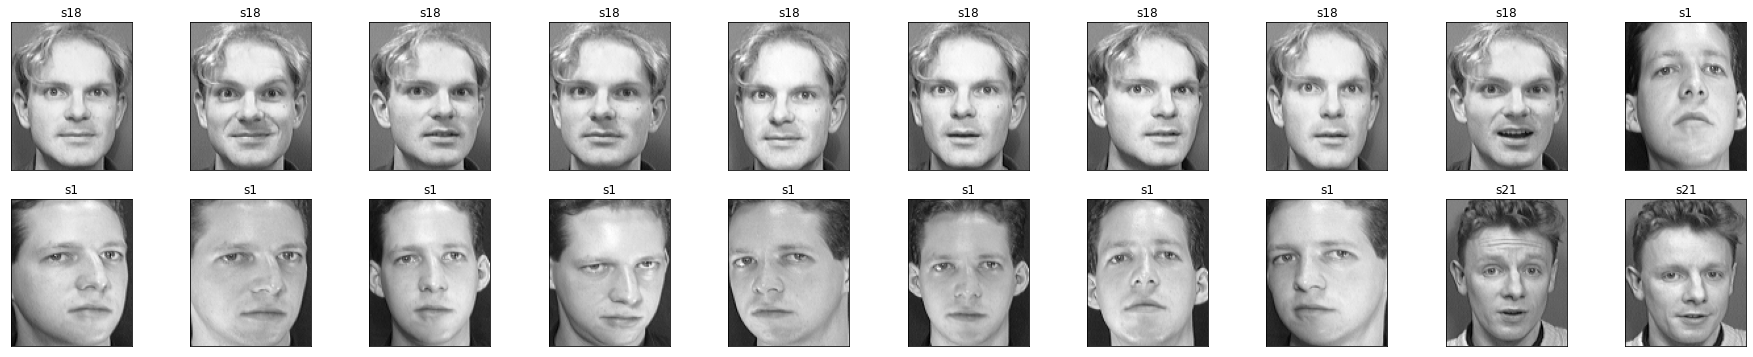

In [45]:
# Size of the images
shape = (112,92) 

# Initialize the array which contains all the images
train_images = np.zeros((total_images, shape[0], shape[1]) ,dtype='float64')
test_images = np.zeros((40, shape[0], shape[1]) ,dtype='float64')
test_images_dict = dict()
id_train = list()
id_test = list()
i = 0
j = 0
# Traverse through the folder which contains all the faces
for folder in glob.glob(path + '/*'):
    # Iterates through all the 10 images in folder and appends in id_train list()
    for q in range(10):
      if q == 9:
        id_test.append(folder[-3:].replace('/', ''))
      else:
        id_train.append(folder[-3:].replace('/', ''))
        # print(folder[-3:])
  
    # Iterates through all the images in folder and add in train_images
    k = 0
    for image in glob.glob(folder + '/*'):
        read_image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        resized_image = cv2.resize(read_image, (shape[1], shape[0]))
        if k == 9:
          test_images[j] = np.array(resized_image)
          test_images_dict[j] = resized_image
          j = j + 1
        else:
          train_images[i] = np.array(resized_image)
          i = i + 1
        # print(train_images[i])
        k = k + 1

# Plots row*col images (20 in this case), first 20 in training set
plot_images(train_images, id_train, 112,92, 2, 10)

# print(id_train, id_test)

The code section below plots the images in test set


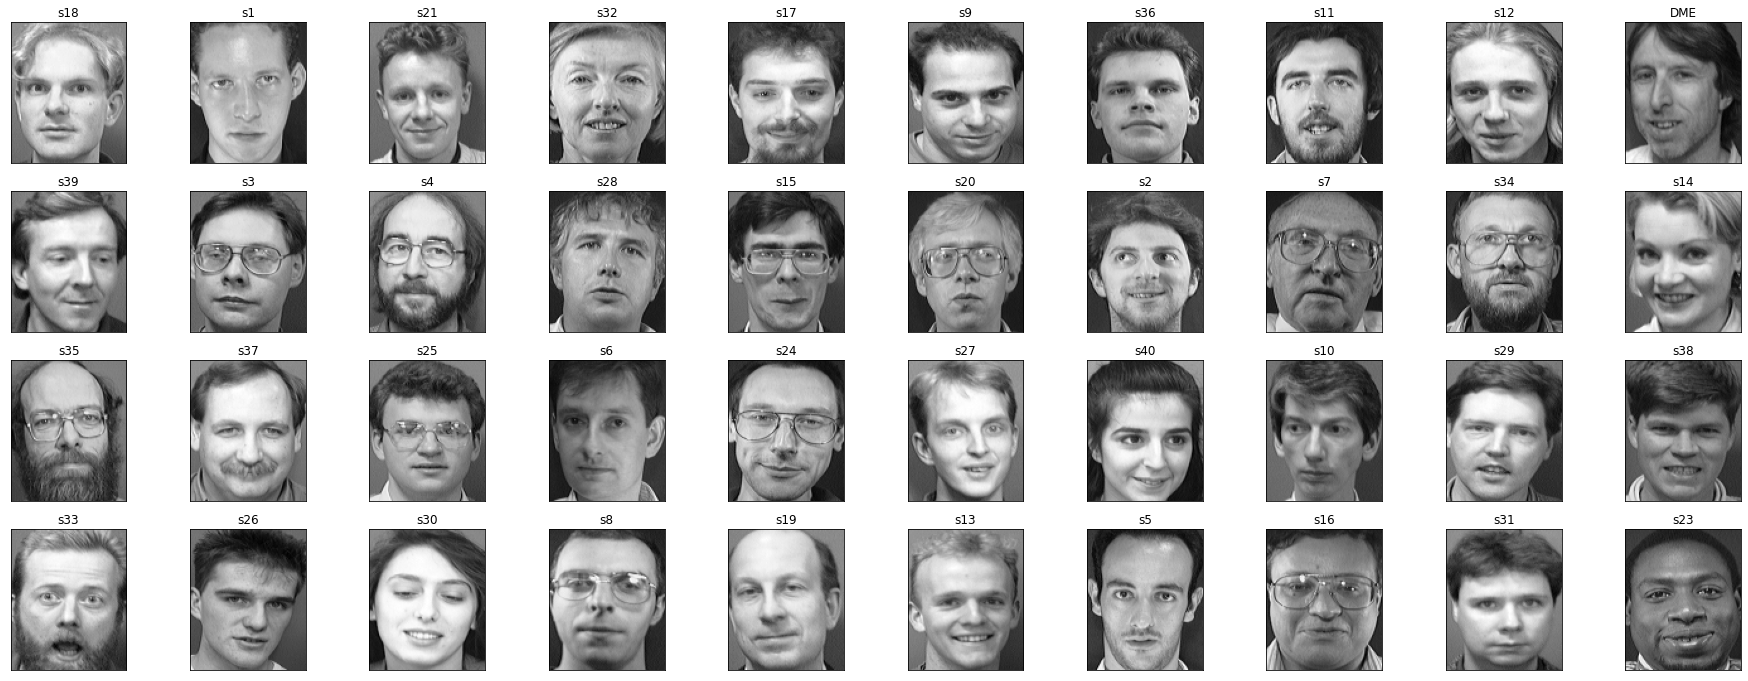

In [46]:
# Plots row*col images (40 in this case, All in test set
plot_images(test_images, id_test, 112, 92, 4, 10)

# The Average Face
The code section plots the mean face of the training set.

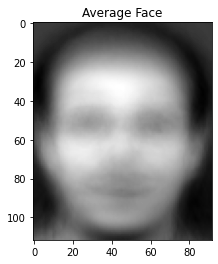

In [47]:
# Convert the nxn image vectors inside train_images matrix to 1 x n^2 matrix and resize
# Finally, F is of the order m x n^2 where m = number of images
F = np.resize(train_images, (total_images, shape[0]*shape[1]))

# The mean matrix is calculated by summing the elements of F and then dividing by total_images
average_vector = np.sum(F, axis=0, dtype='float64')/total_images

# Duplicate average vector into m x n^2 matrix to calculate differences
average_matrix = np.tile(average_vector, (total_images, 1)) 

# Mean subtracted image matrix
F_tilde = F - average_matrix

# Plot the mean image
plt.imshow(np.resize(average_vector, (shape[0],shape[1])), cmap='gray')
plt.title('Average Face')
plt.show()

# Mean Subtracted Image

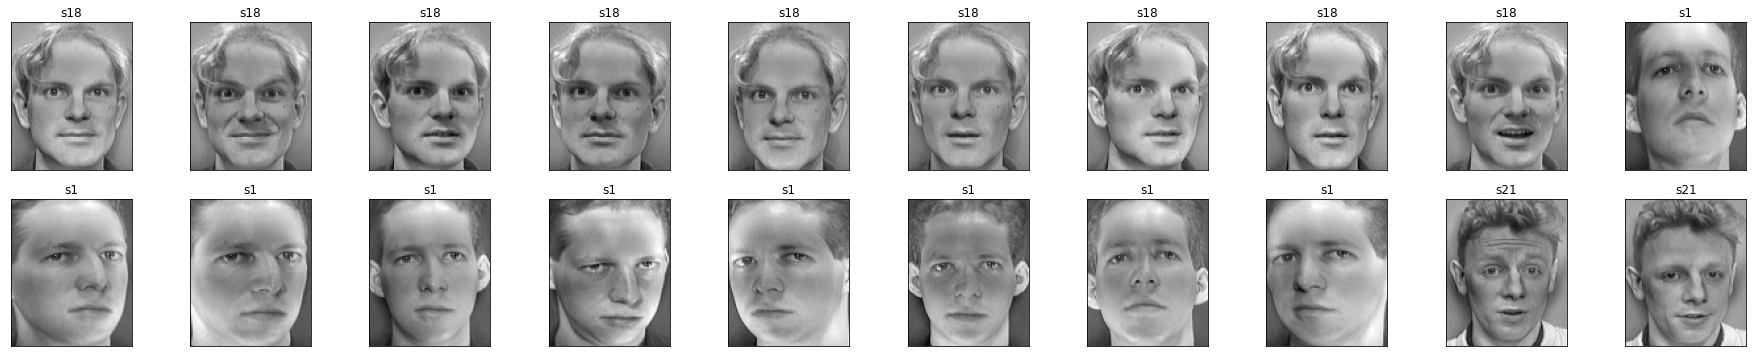

In [48]:
# F_tilde contains vectors of each mean subtracted image
plot_images(F_tilde, id_train, 112,92, 2, 10)

# Eigenfaces

L shape :  (360, 360)
Eigenvectors shape :  (10304, 360)
Eigenfaces shape :  (360, 10304)


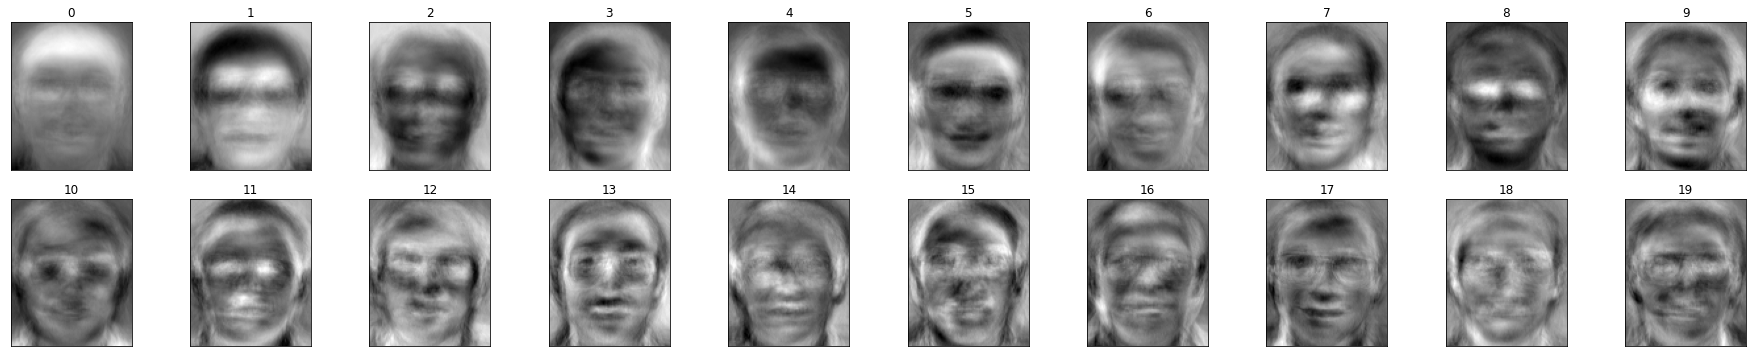

In [49]:
# L is MxM matrix as mentioned in the paper and is used to find out eigenvectors
L = (F_tilde.dot(F_tilde.T))/total_images
print("L shape : ", L.shape)

# Calculate eigenvalues and eigenvectors from L
eigenvalues, eigenvectors = np.linalg.eig(L)

# Sort the eigenvalues and eigenvectors in descending order to obtain highest
# eigenvalue by using the indices
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx] 
eigenvectors = eigenvectors[:, idx]

# Matrix multiplication by linear combinarion of each column of F_tilde
# Resultant contains eigenvector of C in each column
eigenvectors_C = F_tilde.T @ eigenvectors
print("Eigenvectors shape : ", eigenvectors_C.shape)

# Normalize eigenvectors to get eigenfaces
eigenfaces = preprocessing.normalize(eigenvectors_C.T)
print("Eigenfaces shape : ", eigenfaces.shape)

# Plots first 20 eigenfaces
eigenface_labels = [x for x in range(eigenfaces.shape[0])]
plot_images(eigenfaces, eigenface_labels , 112,92, 2, 10) 


# Mean Subtracted Images of the Test Set

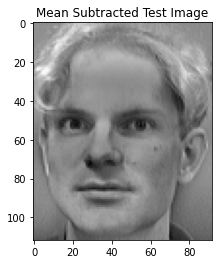

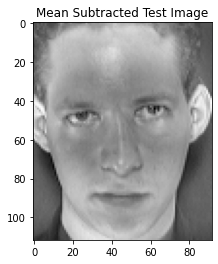

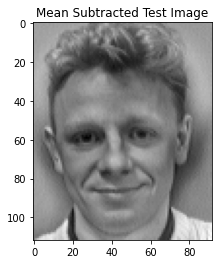

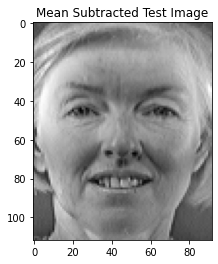

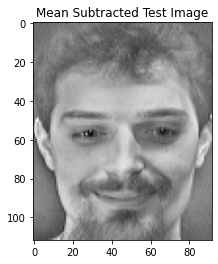

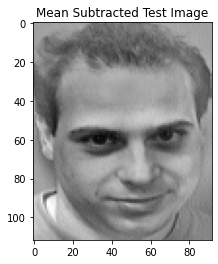

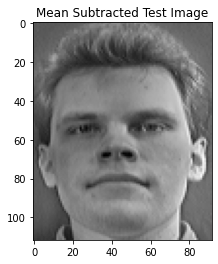

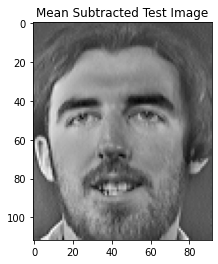

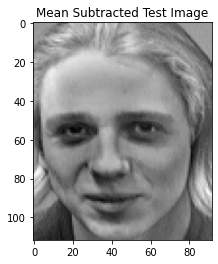

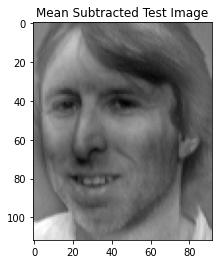

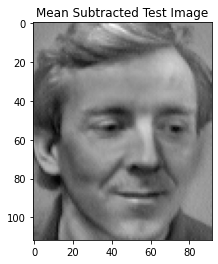

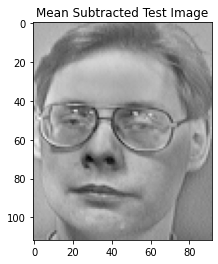

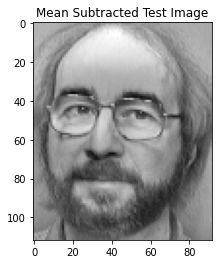

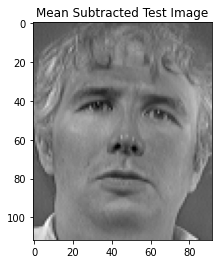

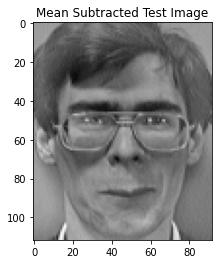

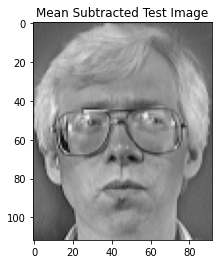

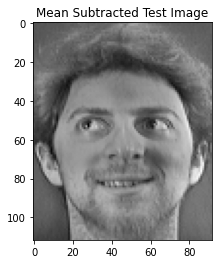

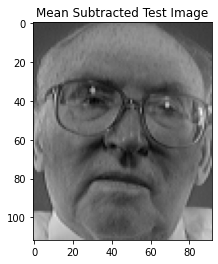

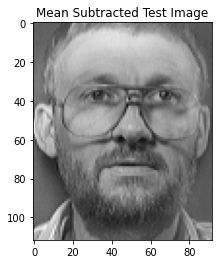

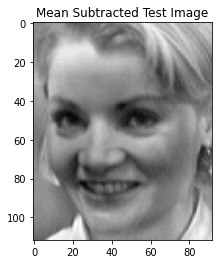

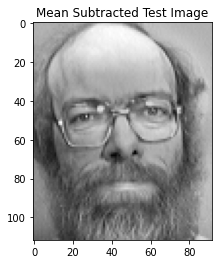

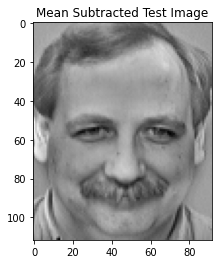

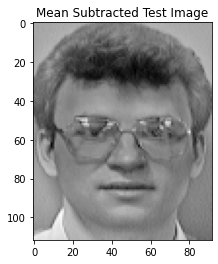

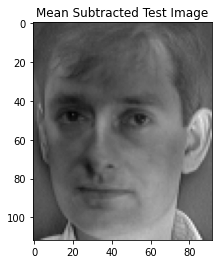

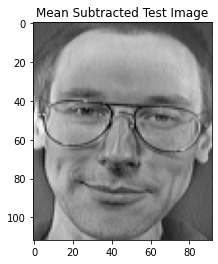

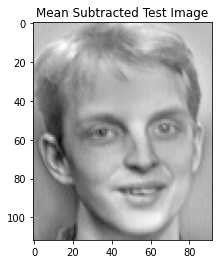

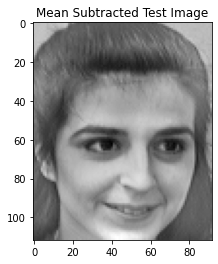

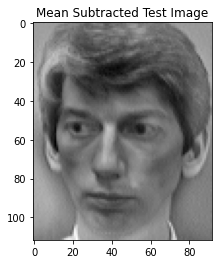

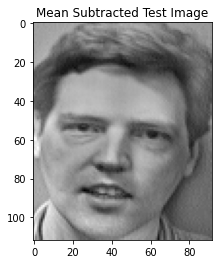

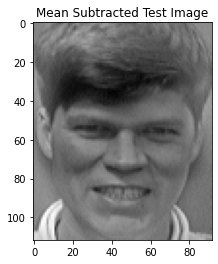

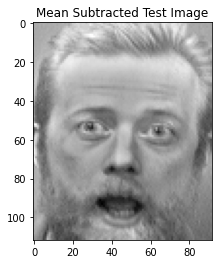

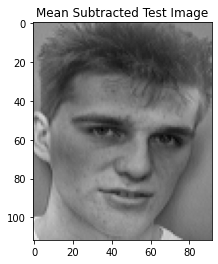

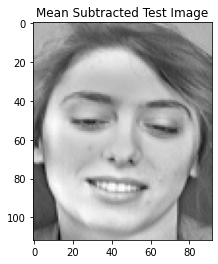

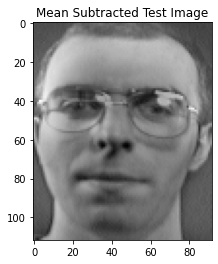

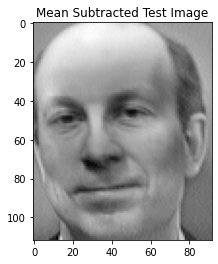

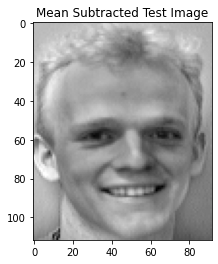

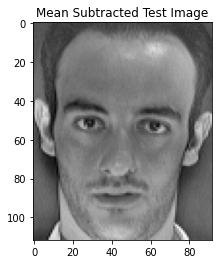

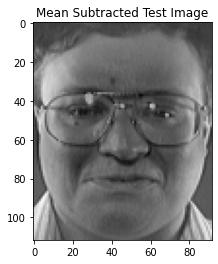

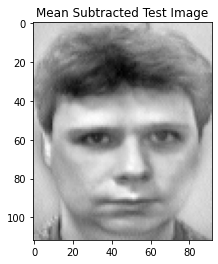

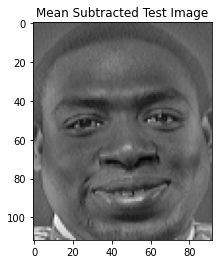

In [50]:
# Stores all the vectors that represent image with respect to the eigenfaces
omega = dict()

# Stores the subtracted mean of the testing images
mean_subtracted_testing_dict = dict()

# The number of chosen eigenfaces
q = 350

def omega_mst(test_image):
  mean_subtracted_testing = np.reshape(test_image, (test_image.shape[0]*test_image.shape[1])) - average_vector
  omega = eigenfaces[:q].dot(mean_subtracted_testing)
  return (mean_subtracted_testing, omega)
  
# Store the values
for j in test_images_dict:
  mean_subtracted_testing_dict[j] = omega_mst(test_images_dict[j])[0]
  omega[j] = omega_mst(test_images_dict[j])[1]
  # print(omega.shape)

# fig = plt.figure(figsize=(10, 7))
  
# # setting values to rows and column variables
# rows = 3
# columns = 3

# # Plot the mean subtracted test image
for j in test_images_dict:
  plt.imshow(np.reshape(mean_subtracted_testing_dict[j], (112,92)), cmap='gray')
  plt.title("Mean Subtracted Test Image")
  plt.show()

  # fig.add_subplot(rows, columns, j+1)

  # # showing image
  # plt.imshow(np.reshape(mean_subtracted_testing_dict[j], (112,92)), cmap='gray')
  # plt.axis('off')
  # plt.title(str(j))

def mst_face(mst):
  plt.imshow(np.reshape(mst, (112,92)), cmap='gray')
  plt.title("Mean Subtracted Test Image")
  plt.show()


# Reconstructed Images of the Test Set

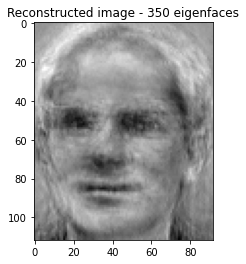

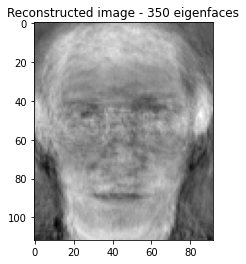

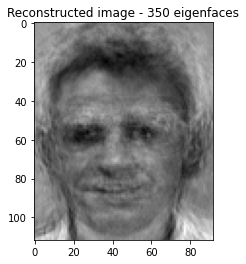

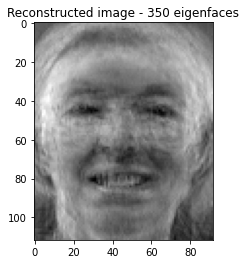

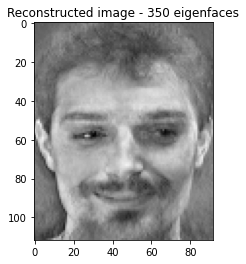

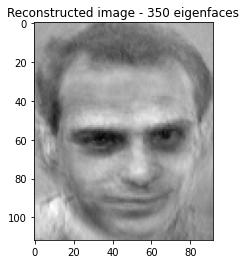

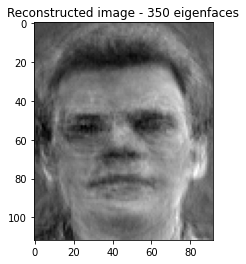

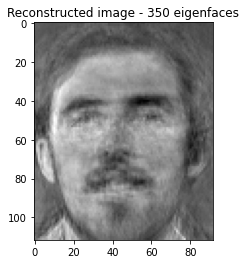

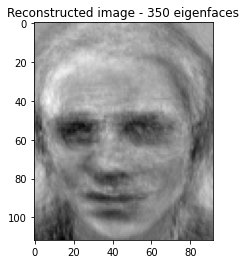

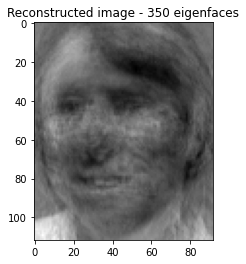

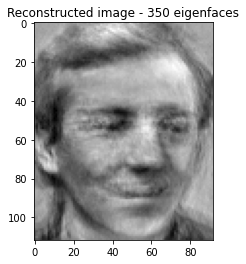

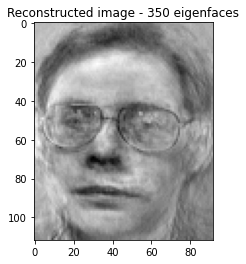

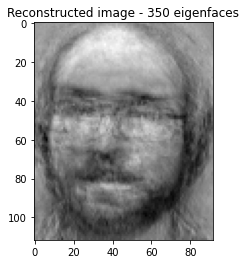

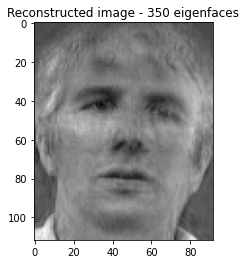

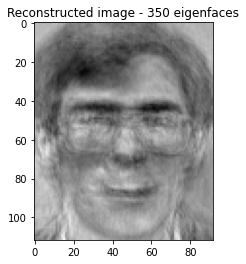

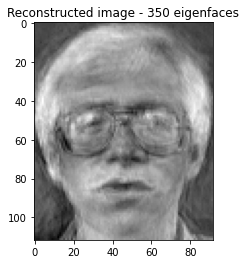

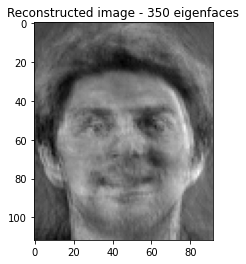

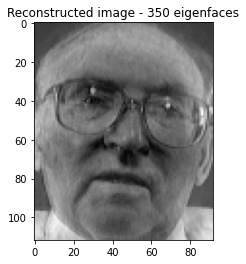

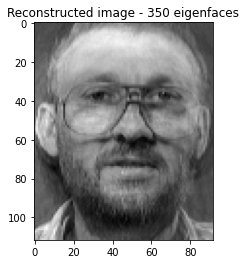

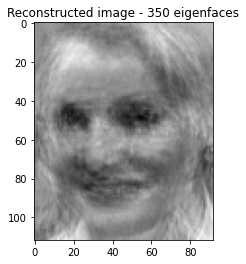

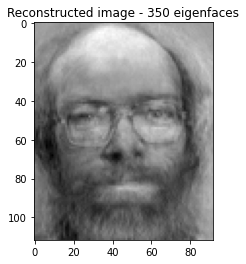

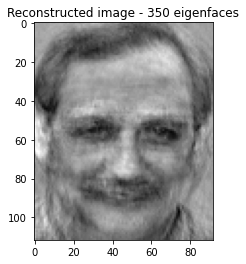

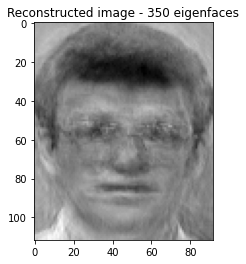

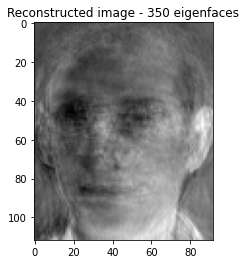

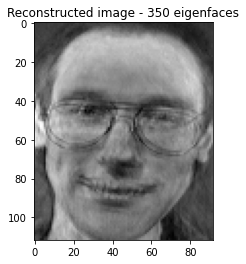

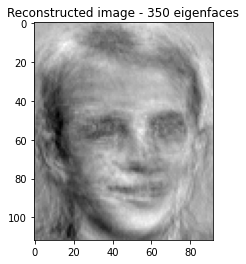

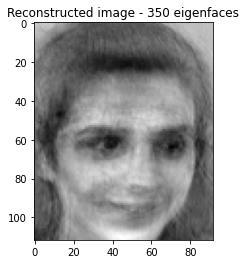

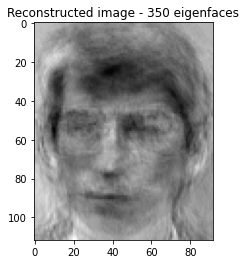

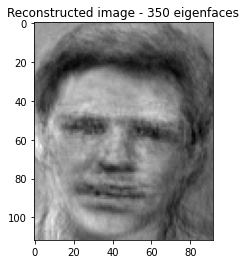

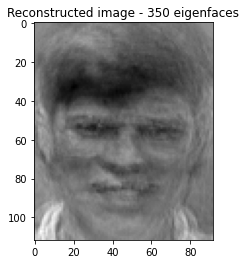

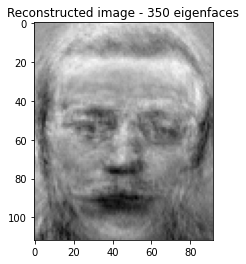

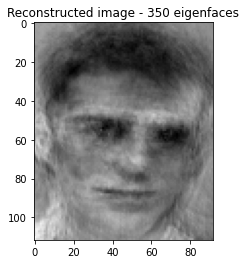

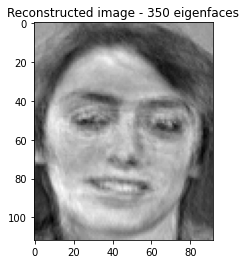

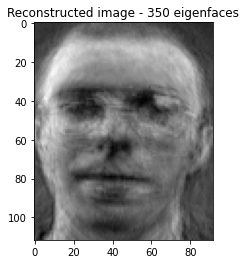

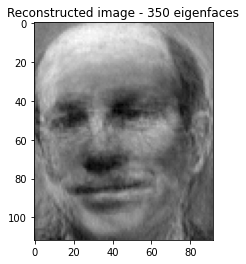

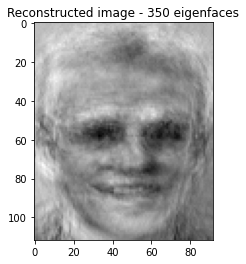

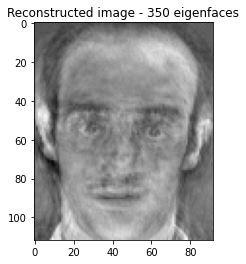

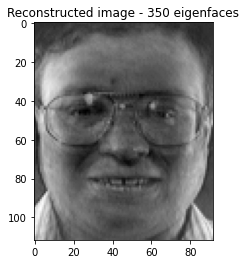

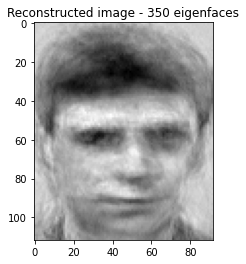

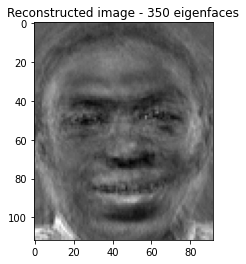

In [51]:
# To plot the reconstructed face image
def face_reconstruct(omega_val):
  # Image reconstruction depends on q eigenfaces
  reconstructed = eigenfaces[:q].T.dot(omega_val) 
  # print(reconstructed.shape)

  plt.imshow(np.reshape(reconstructed, (shape[0],shape[1])), cmap='gray')
  plt.title("Reconstructed image - "+str(q)+" eigenfaces")
  plt.show()

# Plot the reconstructed face image
for i in omega:
  face_reconstruct(omega[i])

# fig = plt.figure(figsize=(10, 7))
  
# # setting values to rows and column variables
# rows = 3
# columns = 3

# # Plot the mean subtracted test image
# for j in range(9):
#   # plt.imshow(np.reshape(mean_subtracted_testing_dict[j], (112,92)), cmap='gray')
#   # plt.title("Mean Subtracted Test Image")
#   # plt.show()

#   fig.add_subplot(rows, columns, j+1)

#   # showing image
#   reconstructed = eigenfaces[:q].T.dot(omega[j]) 
#   # print(reconstructed.shape)
#   plt.imshow(np.reshape(reconstructed, (shape[0],shape[1])), cmap='gray')
#   plt.axis('off')
#   plt.title(str(j))


# Function for face detection
Detects the face using omega and mean subtracted testing values of a particular image. The correct value of alpha_1 is obtained by trial and error. It is 3000 in this case.

In [52]:
def face_detect(omega_val, mean_subtracted_testing_val):
  # Threshold for face detection
  alpha_1 = 3000

  # nxn vector of the test face image represented as the linear combination 
  # of the chosen eigenfaces
  projected_new_img_vector = eigenfaces[:q].T @ omega_val 

  # Beta is the distance between the original face image vector and 
  # the projected vector. Compared with the threshold.
  diff = mean_subtracted_testing_val - projected_new_img_vector 
  beta = math.sqrt(diff.dot(diff)) 

  if beta < alpha_1:
      print("Face detected! ", beta)
  else:
      print("No face detected! ", beta)


for i in omega:
  face_detect(omega[i], mean_subtracted_testing_dict[i])

Face detected!  1457.763885977506
Face detected!  1678.4948706753032
Face detected!  1429.1094824938086
Face detected!  1862.3354446145145
Face detected!  1033.9664578210006
Face detected!  1202.5658645147344
Face detected!  1688.5531461733149
Face detected!  1860.8035781090869
Face detected!  1649.8048597229517
Face detected!  1278.9262520749144
Face detected!  1192.7235378459918
Face detected!  1580.6163730141423
Face detected!  1810.7878275902185
Face detected!  1430.8077922815976
Face detected!  1618.8460830294227
Face detected!  1574.9330961603039
Face detected!  1628.1863816402415
Face detected!  1207.792372630867
Face detected!  1538.230157954824
Face detected!  1623.8836898367733
Face detected!  1634.8171754650623
Face detected!  1194.4019215883802
Face detected!  1386.3118486773426
Face detected!  1393.9320117542586
Face detected!  1601.202822047172
Face detected!  1326.6451817411407
Face detected!  1419.317124310311
Face detected!  1285.000665007869
Face detected!  1287.97256

# Function for Face Recognition
Recognizes faces using the omega value of a particular image. The correct value of alpha_2 is obtained by trial and error. It is 3200 in this case. It returns 4 things.Firstly, it returns all the matching indexes whose value is lower than the threshold. Then it selects the smallest of those values and return the index and the correponsding label/id.

In [53]:
def face_recognize(omega_val):
  # Threshold for face recognition
  alpha_2 = 3200

   # Keep track of the smallest value for face recognition
  smallest_value = None

  # The face image/class that produces the smallest value
  index = None 

  # Indexes of matching images to the given test image 
  matching_indexes = list()

  # Calculate pattern vector and distance to each know class (face image in the
  # traingin dataset)
  for k in range(total_images):
      omega_k = eigenfaces[:q].dot(F_tilde[k])  
      diff = omega_val - omega_k
      epsilon_k = math.sqrt(diff.dot(diff))
      if smallest_value == None:
          smallest_value = epsilon_k
          index = k
      if smallest_value > epsilon_k:
          smallest_value = epsilon_k
          index = k
          matching_indexes.append(k)

  if smallest_value < alpha_2:
      # index += 1
      # print(smallest_value, id_train[index])
      return (smallest_value, id_train[index], index, matching_indexes)
  else:
      # print(smallest_value, "Unknown Face!")
      return (smallest_value, "Unknown Face!", index, matching_indexes)

print("Matching indexes: ")
for i in omega:
  res = face_recognize(omega[i])
  if res[1] == "Unknown Face":
    print(str(i) + ". " + "Above Threshold   Smallest index = " + str(res[2]))
    print("Matching indexes = " + str(res[3]))
  else:
    print(str(i) + ". " + "Below Threshold   Smallest index = " + str(res[2]))
    print("Matching indexes = " + str(res[3]))

print(" ")
print("Result: ")
accuracy = 0
for i in omega:
  res = face_recognize(omega[i])
  if res[1] == "Unknown Face":
    print(str(i) + ". " + "Actual-Id: " + str(id_test[i]) + "   Result: Unkown Face!   smallest_value: " + str(res[0]))
  elif res[1] != id_test[i]:
    print(str(i) + ". " + "Actual-Id: " + str(id_test[i]) + "   Result: " + str(res[1]) + "   smallest_value: " + str(res[0]))
  else:
    print(str(i) + ". " + "Actual-Id: " + str(id_test[i]) + "   Result: " + str(res[1]) + "   smallest_value: " + str(res[0]))
    accuracy += 1
  
percent_accuracy = (accuracy / 40) * 100
print("Correctly recognized: " + str(accuracy) + " images out of 40 images.")
print("Accuracy: " + str(percent_accuracy))



Matching indexes: 
0. Below Threshold   Smallest index = 3
Matching indexes = [1, 3]
1. Below Threshold   Smallest index = 15
Matching indexes = [1, 4, 5, 7, 15]
2. Below Threshold   Smallest index = 20
Matching indexes = [1, 18, 20]
3. Below Threshold   Smallest index = 29
Matching indexes = [1, 3, 27, 28, 29]
4. Below Threshold   Smallest index = 44
Matching indexes = [15, 19, 24, 37, 38, 39, 44]
5. Below Threshold   Smallest index = 51
Matching indexes = [1, 2, 18, 19, 24, 45, 46, 47, 51]
6. Below Threshold   Smallest index = 57
Matching indexes = [1, 4, 15, 18, 19, 24, 25, 39, 54, 57]
7. Below Threshold   Smallest index = 69
Matching indexes = [1, 3, 5, 15, 27, 31, 44, 63, 68, 69]
8. Below Threshold   Smallest index = 74
Matching indexes = [1, 4, 72, 73, 74]
9. Below Threshold   Smallest index = 89
Matching indexes = [1, 15, 18, 20, 81, 82, 86, 89]
10. Below Threshold   Smallest index = 92
Matching indexes = [2, 19, 23, 37, 49, 90, 92]
11. Below Threshold   Smallest index = 102
Mat

# Random Test Set
After testing my algorithm on the test above, I tried using a random test set with very limited images, i.e., only 10 as of now to test the face detection and recogniton. These 10 images are not from any internationally recognized standard datasets. These are just some random images that I found on internet. The algorithm performs satifactorily in this case too. 

You can also see the mean subtracted images and the reconstructed images by running the code section present below.

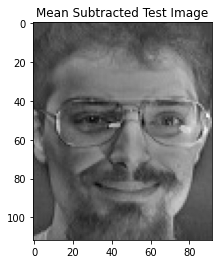

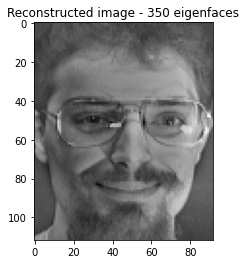

Face detected!  260.13812044346514
26.637020330722425 s17 42 [12, 13, 37, 42]


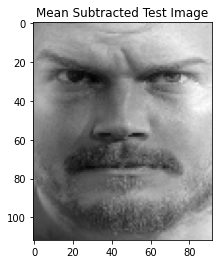

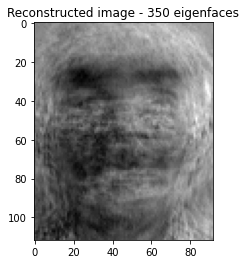

Face detected!  2489.4654023971852
5756.2522907220955 Unknown Face! 187 [1, 2, 8, 18, 186, 187]


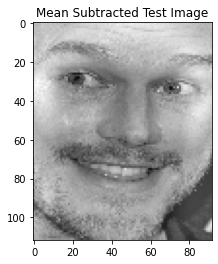

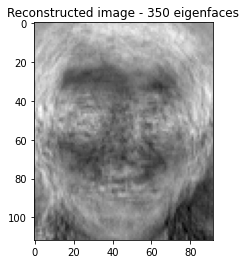

Face detected!  2306.3056255093375
4263.740507621488 Unknown Face! 3 [1, 3]


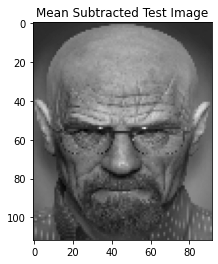

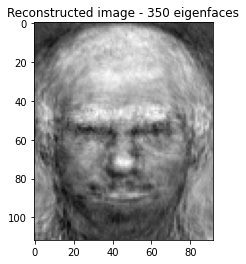

Face detected!  1929.636399299492
4322.295179450308 Unknown Face! 166 [1, 12, 18, 19, 20, 24, 83, 162, 166]


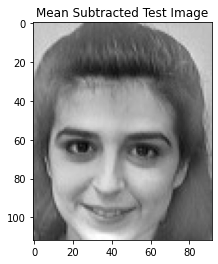

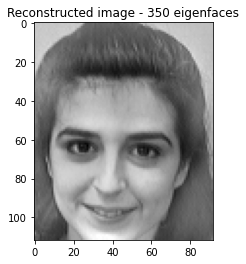

Face detected!  234.77094040723702
26.31400721224369 s40 240 [4, 15, 18, 19, 20, 234, 236, 240]


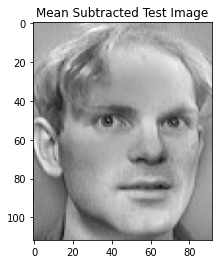

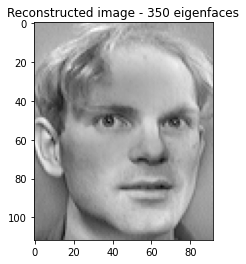

Face detected!  239.59453118827378
25.565353651116734 s18 6 [2, 6]


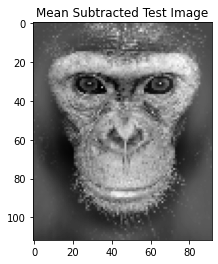

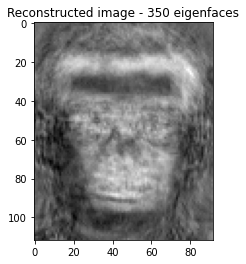

No face detected!  3366.6227838245836
6022.930949748776 Unknown Face! 166 [12, 18, 20, 83, 162, 166]


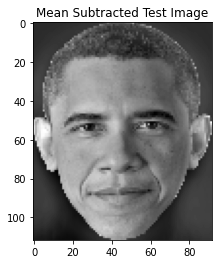

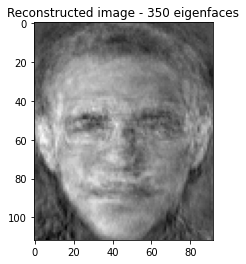

Face detected!  2300.455804626284
4935.600173916786 Unknown Face! 223 [1, 4, 5, 15, 20, 31, 44, 223]


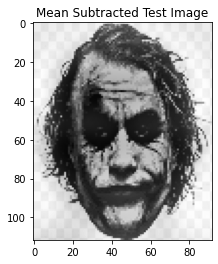

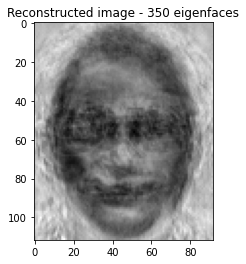

No face detected!  5719.126363334018
10189.30544443693 Unknown Face! 321 [1, 3, 177, 321]


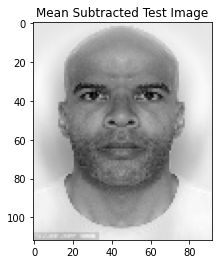

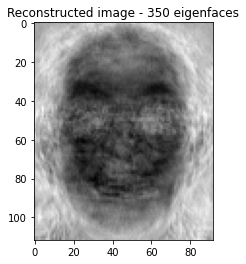

Face detected!  2598.836917459704
8172.418104699671 Unknown Face! 11 [1, 3, 11]


In [54]:
for i in range(1, 11):
  test_img = cv2.imread('/content/sample_data/test'+ str(i)+'.jpg', cv2.IMREAD_GRAYSCALE) #testing image
  test_img = cv2.resize(test_img, (shape[1],shape[0])) #resize the testing image. cv2 resize by width and height.
  mean_subtracted_testing, omega = omega_mst(test_img)[0], omega_mst(test_img)[1]
  mst_face(mean_subtracted_testing)
  face_reconstruct(omega)
  face_detect(omega, mean_subtracted_testing)
  res = face_recognize(omega)
  print(res[0], res[1], res[2], res[3])